#### By: Peyman Shahidi
#### Created: Nov 7, 2025
#### Last Edit: Nov 26, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 
import statsmodels.api as sm
import statsmodels.formula.api as smf


## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
# Set variables
my_onet_level = 'detailed'
onet_occupation_code_var = 'Detailed_Occupation_Code'
onet_occupation_title_var = 'Detailed_Occupation_Title'

ai_exposure_var = 'human_E1_fraction'

FREQUENT_TASKS = False  # Whether to use only frequent tasks or all tasks

In [3]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/fragmentationIndex_frequent' if FREQUENT_TASKS else f'{input_data_path}/computed_objects/fragmentationIndex'
output_plot_path = f"{main_folder_path}/writeup/plots/fragmentationIndex_frequent" if FREQUENT_TASKS else f"{main_folder_path}/writeup/plots/fragmentationIndex"

In [4]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# Read the merged data
if not FREQUENT_TASKS:
    input_file_path = f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv" 
    merged_data = pd.read_csv(input_file_path)

        # Remove occupations with three or less frequent tasks
    frequent_tasks_per_occupation_threshold = 3
    occupation_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
    valid_occupations = occupation_task_counts[occupation_task_counts >= frequent_tasks_per_occupation_threshold].index
    merged_data = merged_data[merged_data['O*NET-SOC Code'].isin(valid_occupations)].reset_index(drop=True)
else:
    input_file_path = f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT_frequent/ONET_Eloundou_Anthropic_GPT.csv"
    merged_data = pd.read_csv(input_file_path)

In [6]:
# Create SOC mappings to merge later
# Read original occupation analysis with SOC mappings
ONET = pd.read_csv(f"{input_data_path}/computed_objects/ONET_cleaned_tasks.csv")

# Keep only the relevant 
SOC_mappings = ONET[['O*NET-SOC Code', 'Occupation Title',
                    'Major_Group_Code', 'Major_Group_Title',
                    'Minor_Group_Code', 'Minor_Group_Title',
                    'Broad_Occupation_Code', 'Broad_Occupation_Title',
                    'Detailed_Occupation_Code', 'Detailed_Occupation_Title']].copy()
SOC_mappings = SOC_mappings.drop_duplicates(subset=['O*NET-SOC Code', onet_occupation_code_var])

In [7]:
def create_occupation_analysis(df, onet_occupation_code_var, onet_occupation_title_var):
    # Create occupation-level analysis for scatter plots
    # Group by occupation and calculate label fractions and task counts
    occupation_stats = []

    for (soc_code, occ_title), group in df.groupby([onet_occupation_code_var, onet_occupation_title_var]):
        num_tasks = group['Task ID'].nunique()
        # num_occupations = group[onet_occupation_code_var].nunique()
        total_tasks = len(group)
        
        manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
        augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
        automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
        ai_fraction = augmentation_fraction + automation_fraction
        gpt4_E0_fraction = (group['gpt4_exposure'] == 'E0').sum() / total_tasks
        gpt4_E1_fraction = (group['gpt4_exposure'] == 'E1').sum() / total_tasks
        gpt4_E2_fraction = (group['gpt4_exposure'] == 'E2').sum() / total_tasks
        gpt4_aiExposure_fraction = gpt4_E1_fraction + gpt4_E2_fraction
        human_E0_fraction = (group['human_labels'] == 'E0').sum() / total_tasks
        human_E1_fraction = (group['human_labels'] == 'E1').sum() / total_tasks
        human_E2_fraction = (group['human_labels'] == 'E2').sum() / total_tasks
        human_aiExposure_fraction = human_E1_fraction + human_E2_fraction

        
        occupation_stats.append({
            f'{onet_occupation_code_var}': soc_code,
            f'{onet_occupation_title_var}': occ_title,
            'num_tasks': num_tasks,
            # 'num_occupations': num_occupations,
            'manual_fraction': manual_fraction,
            'ai_fraction': ai_fraction,
            'augmentation_fraction': augmentation_fraction,
            'automation_fraction': automation_fraction,
            'gpt4_E0_fraction': gpt4_E0_fraction,
            'gpt4_E1_fraction': gpt4_E1_fraction,
            'gpt4_E2_fraction': gpt4_E2_fraction,
            'gpt4_aiExposure_fraction': gpt4_aiExposure_fraction,
            'human_E0_fraction': human_E0_fraction,
            'human_E1_fraction': human_E1_fraction,
            'human_E2_fraction': human_E2_fraction,
            'human_aiExposure_fraction': human_aiExposure_fraction
        })

    occupation_analysis = pd.DataFrame(occupation_stats)

    return occupation_analysis


# Create fragmentation index dataframe for different definitions
def construct_fragmentation_index(df, desired_definition=1, save_filename=None):
    # Definition 1: Separate Augmentation and Automation; AI Chain starts with Automation or Augmentation task and terminates at the first Augmentation task; Get number of switches between AI chains and Manual tasks
    # Definition 2: Treat all AI tasks similarly; Get number of switches between AI chains and Manual tasks
    # Definition 3: Same as Definition 1, but use exposure based label (E1) for forming the "AI-Chain"s
    # Definition 4: Same as Definition 1, but use exposure based label (E1 or E2) for forming the "AI-Chain"s
    fi_df = df.copy()
    
    # Definitions 2, 3, and 4, are basically similar in construction, only differing in the labeling of tasks
    if desired_definition != 1:
        if desired_definition == 2:
            # Use AI execution labels
            fi_df['is_ai'] = fi_df['label'].isin(['Augmentation', 'Automation']).astype(int)
        elif desired_definition == 3:
            # Use exposure based label (E1)
            fi_df['is_ai'] = fi_df['human_labels'].isin(['E1']).astype(int)
        elif desired_definition == 4:
            # Use exposure based label (E1 or E2)
            fi_df['is_ai'] = fi_df['human_labels'].isin(['E1', 'E2']).astype(int)
        
        # Create next_is_ai column within occupation groups
        fi_df['next_is_ai'] = fi_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_ai'].shift(-1).fillna(0).astype(int)

        # Calculate FI using incremental counter: only if current task and next task is AI do not increment FI
        fi_df['num_switches'] = 1
        fi_df.loc[(fi_df['is_ai'] == 1) & (fi_df['next_is_ai'] == 1), 'num_switches'] = 0

    else: # Definition 1
        fi_df['is_automated'] = fi_df['label'].isin(['Automation']).astype(int)
        fi_df['is_augmented'] = fi_df['label'].isin(['Augmentation']).astype(int)

        # Create next_is_automated column within occupation groups
        fi_df['next_is_automated'] = fi_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_automated'].shift(-1).fillna(0).astype(int)
        fi_df['next_is_augmented'] = fi_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['is_augmented'].shift(-1).fillna(0).astype(int)

        # Calculate FI using incremental counter: only if current task and next task is AI do not increment FI
        fi_df['num_switches'] = 1
        ai_chain_indicator = (fi_df['is_automated'] == 1) & ((fi_df['next_is_automated'] == 1) | (fi_df['next_is_augmented'] == 1))
        fi_df.loc[ai_chain_indicator, 'num_switches'] = 0

    # Now with a counter for number of switches, calculate fragmentation index per occupation as mean of num_switches per occupation
    fi_df = fi_df.groupby(['O*NET-SOC Code', 'Occupation Title'])['num_switches'].mean()
    fi_df = fi_df.reset_index().rename(columns={'num_switches': 'fragmentation_index'})

    # Save fragmentation index data
    if save_filename:
        fi_df.to_csv(f"{output_data_path}/{save_filename}", index=False)

    return fi_df



# Merge fragmentation data with occupation analysis
def merge_fragmentation_with_occupation_analysis(fi_df, occupation_analysis, SOC_mappings, onet_occupation_code_var, save_filename=None):
    # Merge fragmentation index with occupation analysis
    occupation_analysis = occupation_analysis.merge(fi_df, on=['O*NET-SOC Code', 'Occupation Title'], how='left')

    # Save occupation analysis with fragmentation index
    if save_filename:
        occupation_analysis.to_csv(f"{output_data_path}/{save_filename}", index=False)

    # Merge SOC levels with the occupation analysis
    occupation_analysis = occupation_analysis.merge(SOC_mappings, on=['O*NET-SOC Code', 'Occupation Title'], how='left')

    return occupation_analysis



# Aggregate occupation analysis at the level of onet_occupation_code_var
def aggregate_occupation_analysis(occupation_analysis, onet_occupation_code_var, onet_occupation_title_var, SOC_mappings, ai_exposure_var):
    occupation_analysis_aggregated = occupation_analysis.groupby(
        [onet_occupation_code_var, onet_occupation_title_var]
    ).agg({
        'fragmentation_index': 'mean',
        ai_exposure_var: 'mean',
        'ai_fraction': 'mean',
        'num_tasks': 'mean'
    }).reset_index()

    # Merge SOC levels for FE
    occupation_analysis_aggregated = occupation_analysis_aggregated.merge(
        SOC_mappings, on=onet_occupation_code_var, how='left', suffixes=('', '_drop')
    )
    occupation_analysis_aggregated = occupation_analysis_aggregated.loc[:, ~occupation_analysis_aggregated.columns.str.endswith('_drop')]

    return occupation_analysis_aggregated

## Calculate Fragmentation Index for 4 Definitions and Run the Regression

In [8]:
regression_results = []

# Create dataset and run regressions for all 4 definitions
for definition in [1, 2, 3, 4]:
    # Get occupation data
    occupation_analysis = create_occupation_analysis(merged_data, 'O*NET-SOC Code', 'Occupation Title')

    # Get fragmentation index
    fi_df = construct_fragmentation_index(merged_data, desired_definition=definition, save_filename=f'fragmentationIndex_def{definition}.csv')

    # Merge fragmentation data with occupation analysis
    occupation_analysis = merge_fragmentation_with_occupation_analysis(fi_df, occupation_analysis, SOC_mappings, onet_occupation_code_var, save_filename=f'occupation_analysis_with_fragmentationIndex_def{definition}.csv')

    # Aggregate data at the onet_occupation_code_var level and add back SOC code information
    occupation_analysis_aggregated = aggregate_occupation_analysis(occupation_analysis, onet_occupation_code_var, onet_occupation_title_var, SOC_mappings, ai_exposure_var)

    # Rename regression columns for clarity
    occupation_analysis_aggregated = occupation_analysis_aggregated.rename(columns={
        ai_exposure_var: 'ai_exposure'
    })

    # Run regressions, clustering standard errors at the onet_occupation_code_var level
    # --- Model A: no FE ---
    mod_noFE = smf.ols(
        formula=f'ai_fraction ~ fragmentation_index + ai_exposure',
        data=occupation_analysis_aggregated
        ).fit(cov_type="cluster",
            cov_kwds={"groups": occupation_analysis_aggregated[onet_occupation_code_var],
                        "use_correction": True,
                        "df_correction": True}
                        )
    regression_results.append(mod_noFE)

    # --- Model B (Major group FE) ---
    mod_majorFE = smf.ols(
        formula=f'ai_fraction ~ fragmentation_index + ai_exposure + C(Major_Group_Code)',
        data=occupation_analysis_aggregated
        ).fit(cov_type="cluster",
            cov_kwds={"groups": occupation_analysis_aggregated[onet_occupation_code_var],
                        "use_correction": True,
                        "df_correction": True}
                        )
    regression_results.append(mod_majorFE)

    # --- Model C (Minor group FE) ---
    mod_minorFE = smf.ols(
        formula=f'ai_fraction ~ fragmentation_index + ai_exposure + C(Minor_Group_Code)',
        data=occupation_analysis_aggregated
        ).fit(cov_type="cluster",
            cov_kwds={"groups": occupation_analysis_aggregated[onet_occupation_code_var],
                        "use_correction": True,
                        "df_correction": True}
                        )
    regression_results.append(mod_minorFE)

In [9]:
from statsmodels.iolib.summary2 import summary_col

def latex_table_cleanup(results_table):
    latex_table = results_table.as_latex()
    
    # --- Ensure a single \hline before R-squared ---
    latex_table = latex_table.replace('\nR-squared', '\n\\hline\nR-squared')
    latex_table = latex_table.replace('\n\\hline\nR-squared Adj.', '\nR-squared Adj.')

    # --- Add centered note below final \hline (inside table) ---
    note_text = (
        '\\\\[-1.25em]\n'
        '\\multicolumn{4}{l}{Standard errors in parentheses.} \\\\\n'
        '\\multicolumn{4}{l}{$^{*}:p<0.1$, $^{**}:p<0.05$, $^{***}:p<0.01$} \\\\\n'
    )

    latex_table = latex_table.replace(
        r'\hline' + '\n\\end{tabular}',
        r'\hline' + note_text + r'\end{tabular}'
    )

    return latex_table


def insert_group_header(latex_table, group_labels, group_sizes):
    """Insert a grouped header row into a LaTeX table produced by summary_col.

    group_labels: list of strings for each group (e.g., ['FI v1','FI v2'])
    group_sizes: list of ints with how many model columns each group spans (e.g., [3,3])
    """
    marker = '\n\\hline\n'
    idx = latex_table.find(marker)
    if idx == -1:
        return latex_table
    insert_pos = idx + len(marker)

    # Build the grouped row. Leading empty cell for the variable name column.
    parts = []
    for label, size in zip(group_labels, group_sizes):
        parts.append(r"\\multicolumn{" + str(size) + r"}{c}{" + label + r"}")

    group_row = ' & ' + ' & '.join(parts) + r' \\' + '\n'

    return latex_table[:insert_pos] + group_row + latex_table[insert_pos:]


# ---- Combine models into a table ----
info_dict = {
    'N': lambda x: f"{int(x.nobs):,}",
    'SOC Group Fixed Effects': lambda x: (
        '' if 'C(Major_Group_Code)' not in x.model.formula and 'C(Minor_Group_Code)' not in x.model.formula
        else 'Major' if 'C(Major_Group_Code)' in x.model.formula
        else 'Minor'
    )
}

regressor_order = ['ai_exposure', 'fragmentation_index']

results_table_1 = summary_col(
    results=regression_results[:6],
    float_format='%0.2f',
    stars=True,
    model_names=['(1)', '(2)', '(3)', 
                 '(4)', '(5)', '(6)'],
    info_dict=info_dict,
    regressor_order=regressor_order,
    drop_omitted=True
)
latex_table_1 = latex_table_cleanup(results_table_1)
# Insert grouped header for definitions 1 & 2 (three models each)
latex_table_1 = insert_group_header(latex_table_1, ['FI v1', 'FI v2'], [3, 3])

# Save LaTeX table to file
output_path = f"{output_data_path}/fragmentation_index_regression_1.tex"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, "w", encoding="utf-8") as f:
    f.write(latex_table_1)
print(latex_table_1)



results_table_2 = summary_col(
    results=regression_results[6:],
    float_format='%0.2f',
    stars=True,
    model_names=['(7)', '(8)', '(9)',
                 '(10)', '(11)', '(12)'],
    info_dict=info_dict,
    regressor_order=regressor_order,
    drop_omitted=True
)
latex_table_2 = latex_table_cleanup(results_table_2)
# Insert grouped header for definitions 3 & 4 (three models each)
latex_table_2 = insert_group_header(latex_table_2, ['FI v3', 'FI v4'], [3, 3])

# Save LaTeX table to file
output_path = f"{output_data_path}/fragmentation_index_regression_2.tex"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, "w", encoding="utf-8") as f:
    f.write(latex_table_2)
print(latex_table_2)


\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hline
 & \\multicolumn{3}{c}{FI v1} & \\multicolumn{3}{c}{FI v2} \\
                        & (1)      & (2)      & (3)      & (4)      & (5)      & (6)       \\
\hline
ai\_exposure            & 0.43***  & 0.20***  & 0.15***  & 0.26***  & 0.13***  & 0.11***   \\
                        & (0.03)   & (0.04)   & (0.05)   & (0.02)   & (0.03)   & (0.03)    \\
fragmentation\_index    & -2.58*** & -1.97*** & -1.68*** & -1.48*** & -1.29*** & -1.24***  \\
                        & (0.12)   & (0.15)   & (0.17)   & (0.05)   & (0.05)   & (0.06)    \\
\hline
R-squared               & 0.65     & 0.74     & 0.80     & 0.84     & 0.87     & 0.90      \\
R-squared Adj.          & 0.65     & 0.74     & 0.77     & 0.84     & 0.87     & 0.88      \\
N                       & 872      & 872      & 872      & 872      & 872      & 872       \\
SOC Group Fixed Effects &          & Major    & Minor    &          & Major    & Minor     

In [10]:
# Combine the two LaTeX tables into a single tabular with two panels
import os
import re

tex1_path = os.path.join(output_data_path, 'fragmentation_index_regression_1.tex')
tex2_path = os.path.join(output_data_path, 'fragmentation_index_regression_2.tex')
output_combined_path = os.path.join(output_data_path, 'fragmentation_index_regression.tex')


def extract_tabular_block(tex):
    m = re.search(r"\\begin\{tabular\}\{.*?\}(.*?)\\end\{tabular\}", tex, flags=re.S)
    return m.group(1) if m else ''


def extract_rows(block):
    # Normalize and split into non-empty lines
    lines = [l.strip() for l in block.splitlines() if l.strip() != '']

    def find_index_containing(substr):
        for i, l in enumerate(lines):
            if substr in l:
                return i
        return None

    ai_idx = find_index_containing('ai\\_exposure')
    frag_idx = find_index_containing('fragmentation\\_index')

    ai_line = lines[ai_idx] if ai_idx is not None else ''
    ai_se = lines[ai_idx + 1] if ai_idx is not None and ai_idx + 1 < len(lines) else ''
    frag_line = lines[frag_idx] if frag_idx is not None else ''
    frag_se = lines[frag_idx + 1] if frag_idx is not None and frag_idx + 1 < len(lines) else ''

    def find_starting(prefix):
        for l in lines:
            if l.startswith(prefix):
                return l
        return ''

    r2 = find_starting('R-squared')
    r2adj = find_starting('R-squared Adj.')
    N = find_starting('N')
    soc = find_starting('SOC Group Fixed Effects')

    return {
        'ai_line': ai_line,
        'ai_se': ai_se,
        'frag_line': frag_line,
        'frag_se': frag_se,
        'R2': r2,
        'R2adj': r2adj,
        'N': N,
        'SOC': soc,
    }


# Read both files
with open(tex1_path, 'r', encoding='utf-8') as f:
    tex1 = f.read()
with open(tex2_path, 'r', encoding='utf-8') as f:
    tex2 = f.read()

block1 = extract_tabular_block(tex1)
block2 = extract_tabular_block(tex2)
rows1 = extract_rows(block1)
rows2 = extract_rows(block2)

# Build combined tabular block (only the tabular, ready to paste into a .tex file)
lines = []
lines.append('\\begin{tabular}{lcccccc}')
lines.append('\\multicolumn{7}{l}{Panel (A)} \\\\')
lines.append('\\hline')
lines.append('                        & \\multicolumn{3}{c|}{FI v1} & \\multicolumn{3}{c}{FI v2} \\\\')
lines.append(' \\cline{2-7}')
lines.append('                        & (1)      & (2)      & (3)      & (4)      & (5)      & (6)       \\\\')
lines.append('\\hline')
# append coefficient lines (assume they already have correct number of columns)
lines.append(rows1['ai_line'])
lines.append(rows1['ai_se'])
lines.append(rows1['frag_line'])
lines.append(rows1['frag_se'])
lines.append('\\hline')
lines.append(rows1['R2'])
lines.append(rows1['R2adj'])
lines.append(rows1['N'])
lines.append(rows1['SOC'])
lines.append('\\\\[-0.5em]')
lines.append('\\multicolumn{7}{l}{Panel (B)} \\\\')
lines.append('\\hline')
lines.append('                        & \\multicolumn{3}{c|}{FI v3} & \\multicolumn{3}{c}{FI v4} \\\\')
lines.append(' \\cline{2-7}')
lines.append('                        & (7)     & (8)    & (9)    & (10)     & (11)     & (12)       \\\\')
lines.append('\\hline')
lines.append(rows2['ai_line'])
lines.append(rows2['ai_se'])
lines.append(rows2['frag_line'])
lines.append(rows2['frag_se'])
lines.append('\\hline')
lines.append(rows2['R2'])
lines.append(rows2['R2adj'])
lines.append(rows2['N'])
lines.append(rows2['SOC'])
lines.append('\\hline')
lines.append('\\\\[-1em]')
lines.append('\\multicolumn{7}{l}{\\footnotesize Standard errors in parentheses.} \\\\')
lines.append('\\multicolumn{7}{l}{\\footnotesize $^{*}:p<0.1$, $^{**}:p<0.05$, $^{***}:p<0.01$} \\\\')
lines.append('\\end{tabular}')

combined_tabular = '\n'.join(lines)

# Write only the tabular piece to the file (no surrounding table/resizing environment)
os.makedirs(os.path.dirname(output_combined_path), exist_ok=True)
with open(output_combined_path, 'w', encoding='utf-8') as f:
    f.write(combined_tabular)

print(f'Wrote combined tabular to: {output_combined_path}')


Wrote combined tabular to: ../data/computed_objects/fragmentationIndex/fragmentation_index_regression.tex


## Plot Fragmentation Index Against AI Exposure

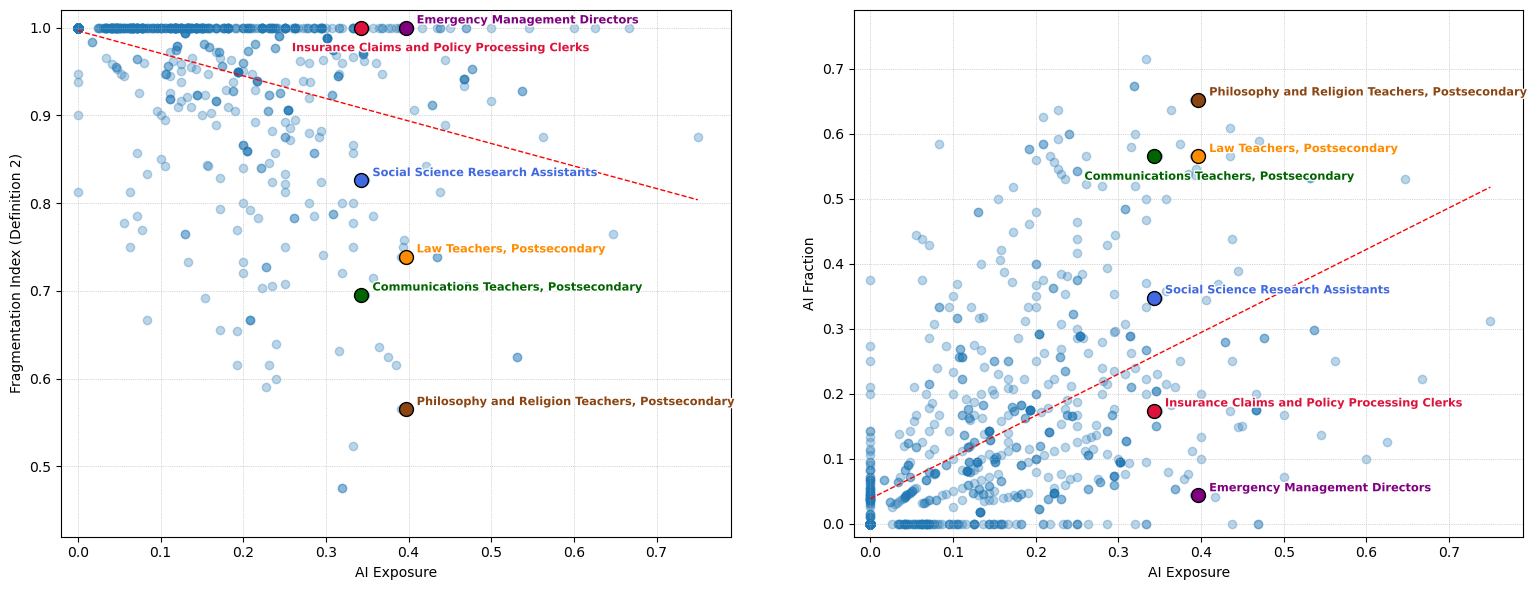

Saved combined figure to: ../writeup/plots/fragmentationIndex/fragmentation_and_aiFraction_vs_aiExposure.png


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import os

# ---- PREP SHARED DATA ----
occupation_analysis = create_occupation_analysis(merged_data, 'O*NET-SOC Code', 'Occupation Title')
fi_df = construct_fragmentation_index(merged_data, desired_definition=2)
occupation_analysis = merge_fragmentation_with_occupation_analysis(
    fi_df, occupation_analysis, SOC_mappings, onet_occupation_code_var, save_filename=None
)
occupation_analysis_aggregated = aggregate_occupation_analysis(
    occupation_analysis, onet_occupation_code_var, onet_occupation_title_var, SOC_mappings, ai_exposure_var
)

occupation_analysis_aggregated = occupation_analysis_aggregated.rename(columns={ai_exposure_var: 'ai_exposure'})
os.makedirs(output_plot_path, exist_ok=True)

# ---- CREATE FIGURE ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

highlight_map = {
    '43-9041': 'crimson',      # vivid, deeper red (cleaner than "red")
    '19-4061': 'royalblue',    # bright but not harsh
    '25-1122': 'darkgreen',    # strong green, excellent contrast
    '11-9161': 'purple',       # saturated and unique
    '25-1112': 'darkorange',    # warm yellow with good visibility
    '25-1126': 'saddlebrown'         # neutral but stands out; great for labels too
}

legend_map = {
    '43-9041': 'Insurance Claims and Policy Processing Clerks',
    '19-4061': 'Social Science Research Assistants',
    '25-1122': 'Communications Teachers, Postsecondary',
    '11-9161': 'Emergency Management Directors',
    '25-1112': 'Law Teachers, Postsecondary',
    '25-1126': 'Philosophy and Religion Teachers, Postsecondary'
}

# ---- GROUPS FOR JITTER ----
group1 = ['43-9041','19-4061','25-1122']   # first 3
group2 = ['11-9161','25-1112','25-1126']   # second 3
jitter_amount = 0.005

# ---- CUSTOM OFFSETS ----
offsets_A = {
    '43-9041': (-50, -17),  # red bin → left + down
    '19-4061': (8, 3),
    '25-1122': (8, 3),
    '11-9161': (8, 3),
    '25-1112': (8, 3),
    '25-1126': (8, 3)
}

offsets_B = {
    '25-1122': (-50, -17),  # orange bin → left + down (panel B)
    '43-9041': (8, 3),
    '19-4061': (8, 3),
    '11-9161': (8, 3),
    '25-1112': (8, 3),
    '25-1126': (8, 3)
}

###############################################
# Panel A — Fragmentation index vs AI exposure
###############################################

df_plot = occupation_analysis_aggregated.dropna(subset=['fragmentation_index', 'ai_exposure']).copy()
x = df_plot['ai_exposure']
y = df_plot['fragmentation_index']

ax = axes[0]
ax.scatter(x, y, alpha=0.3, label='_nolegend_')

# Linear fit
if len(x) > 1:
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    ax.plot(xs, m*xs + b, color='red', linewidth=1, linestyle='--')

# Highlight + annotate
for soc_code, color in highlight_map.items():
    sub = df_plot[df_plot[onet_occupation_code_var] == soc_code]
    if not sub.empty:
        hx, hy = sub['ai_exposure'].values[0], sub['fragmentation_index'].values[0]

        # --- Apply jitter ---
        if soc_code in group1:
            hx -= jitter_amount
        elif soc_code in group2:
            hx += jitter_amount

        # Plot point
        ax.scatter(hx, hy, s=100, facecolors=color, edgecolors='black', linewidths=1, zorder=2)

        # --- Annotate ---
        dx, dy = offsets_A[soc_code]
        ax.annotate(
            legend_map[soc_code],
            xy=(hx, hy),
            xytext=(dx, dy),
            textcoords='offset points',
            fontsize=8.2,
            color=color,
            weight='bold',
            path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
        )

r = np.corrcoef(x, y)[0,1] if len(x) > 1 else np.nan

ax.set_xlabel(f'AI Exposure')
ax.set_ylabel('Fragmentation Index (Definition 2)')
# ax.set_title(f'Fragmentation Index vs AI exposure (r={r:.2f})')
ax.grid(True, linestyle=':', linewidth=0.5)
ax.set_xlim(-0.02, 0.79)
ax.set_ylim(0.42, 1.02)

###############################################
# Panel B — AI fraction vs AI exposure
###############################################

df_plot = occupation_analysis_aggregated.dropna(subset=['ai_fraction','ai_exposure']).copy()
x = df_plot['ai_exposure']
y = df_plot['ai_fraction']

ax = axes[1]
ax.scatter(x, y, alpha=0.3, label='_nolegend_')

# Linear fit
if len(x) > 1:
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    ax.plot(xs, m*xs + b, color='red', linewidth=1, linestyle='--')

# Highlight + annotate
for soc_code, color in highlight_map.items():
    sub = df_plot[df_plot[onet_occupation_code_var] == soc_code]
    if not sub.empty:
        hx, hy = sub['ai_exposure'].values[0], sub['ai_fraction'].values[0]

        # --- Apply jitter ---
        if soc_code in group1:
            hx -= jitter_amount
        elif soc_code in group2:
            hx += jitter_amount

        ax.scatter(hx, hy, s=100, facecolors=color, edgecolors='black', linewidths=1, zorder=2)

        # annotation offsets
        dx, dy = offsets_B[soc_code]
        ax.annotate(
            legend_map[soc_code],
            xy=(hx, hy),
            xytext=(dx, dy),
            textcoords='offset points',
            fontsize=8.2,
            color=color,
            weight='bold',
            path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
        )

r = np.corrcoef(x, y)[0,1] if len(x) > 1 else np.nan

ax.set_xlabel(f'AI Exposure')
ax.set_ylabel('AI Fraction')
# ax.set_title(f'AI Fraction vs AI Exposure (r={r:.2f})')
ax.grid(True, linestyle=':', linewidth=0.5)
ax.set_xlim(-0.02, 0.79)
ax.set_ylim(-0.02, 0.79)

plt.tight_layout()

outfile = os.path.join(output_plot_path, 'fragmentation_and_aiFraction_vs_aiExposure.png')
plt.savefig(outfile, dpi=300)
plt.show()

print(f"Saved combined figure to: {outfile}")

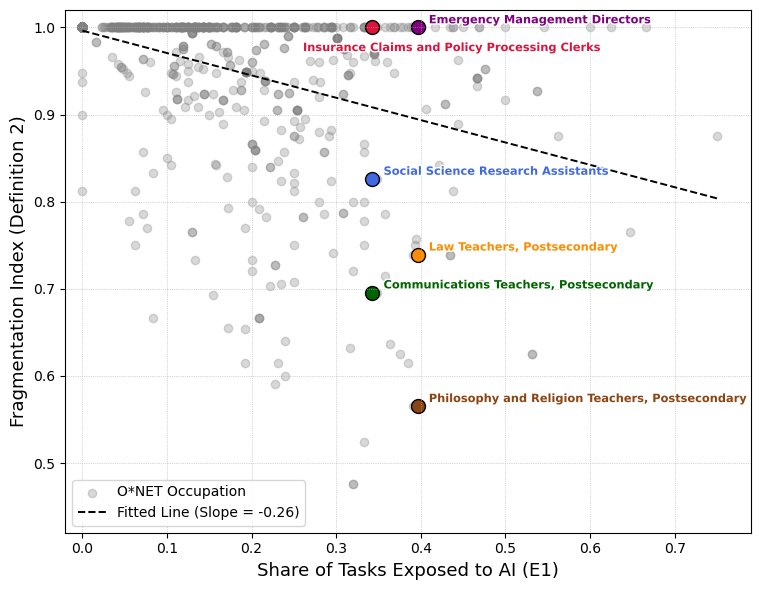

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import os

# ---- PREP SHARED DATA ----
occupation_analysis = create_occupation_analysis(merged_data, 'O*NET-SOC Code', 'Occupation Title')
fi_df = construct_fragmentation_index(merged_data, desired_definition=2)
occupation_analysis = merge_fragmentation_with_occupation_analysis(
    fi_df, occupation_analysis, SOC_mappings, onet_occupation_code_var, save_filename=None
)
occupation_analysis_aggregated = aggregate_occupation_analysis(
    occupation_analysis, onet_occupation_code_var, onet_occupation_title_var, SOC_mappings, ai_exposure_var
)
occupation_analysis_aggregated = occupation_analysis_aggregated.rename(columns={ai_exposure_var: 'ai_exposure'})

os.makedirs(output_plot_path, exist_ok=True)

highlight_map = {
    '43-9041': 'crimson',
    '19-4061': 'royalblue',
    '25-1122': 'darkgreen',
    '11-9161': 'purple',
    '25-1112': 'darkorange',
    '25-1126': 'saddlebrown'
}

legend_map = {
    '43-9041': 'Insurance Claims and Policy Processing Clerks',
    '19-4061': 'Social Science Research Assistants',
    '25-1122': 'Communications Teachers, Postsecondary',
    '11-9161': 'Emergency Management Directors',
    '25-1112': 'Law Teachers, Postsecondary',
    '25-1126': 'Philosophy and Religion Teachers, Postsecondary'
}

group1 = ['43-9041','19-4061','25-1122']
group2 = ['11-9161','25-1112','25-1126']
jitter_amount = 0.005

offsets_A = {
    '43-9041': (-50, -17),
    '19-4061': (8, 3),
    '25-1122': (8, 3),
    '11-9161': (8, 3),
    '25-1112': (8, 3),
    '25-1126': (8, 3)
}

# ----- FIGURE -----
plt.figure(figsize=(8,6))
ax = plt.gca()

df_plot = occupation_analysis_aggregated.dropna(subset=['fragmentation_index', 'ai_exposure']).copy()
x = df_plot['ai_exposure']
y = df_plot['fragmentation_index']

# Background cloud
ax.scatter(x, y, alpha=0.3, color='gray', label='O*NET Occupation')

# Trendline
if len(x):
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    ax.plot(xs, m*xs + b, color='black', linestyle='--', linewidth=1.4, label=f'Fitted Line (Slope = {m:.2f})')

# Highlight + annotate
for soc_code, color in highlight_map.items():
    sub = df_plot[df_plot[onet_occupation_code_var] == soc_code]
    if not sub.empty:
        hx = sub['ai_exposure'].iloc[0]
        hy = sub['fragmentation_index'].iloc[0]
        if soc_code in group1: hx -= jitter_amount
        elif soc_code in group2: hx += jitter_amount

        ax.scatter(hx, hy, s=100, color=color, edgecolors='black', linewidth=1)

        dx, dy = offsets_A[soc_code]
        ax.annotate(
            legend_map[soc_code], 
            xy=(hx, hy), 
            xytext=(dx, dy),
            textcoords='offset points',
            fontsize=8.2, 
            color=color,
            weight='bold',
            path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
        )

r = np.corrcoef(x, y)[0,1] if len(x)>1 else np.nan

ax.set_xlabel("Share of Tasks Exposed to AI (E1)", fontsize=13)
ax.set_ylabel("Fragmentation Index (Definition 2)", fontsize=13)
# ax.set_title(f"Fragmentation Index vs AI Exposure (r={r:.2f})")
ax.grid(True, linestyle=':', linewidth=0.5)
ax.set_xlim(-0.02, 0.79)
ax.set_ylim(0.42, 1.02)
ax.legend(loc='lower left')

plt.tight_layout()
plt.savefig(os.path.join(output_plot_path, "fragmentation_vs_aiExposure.png"), dpi=300)
plt.show()

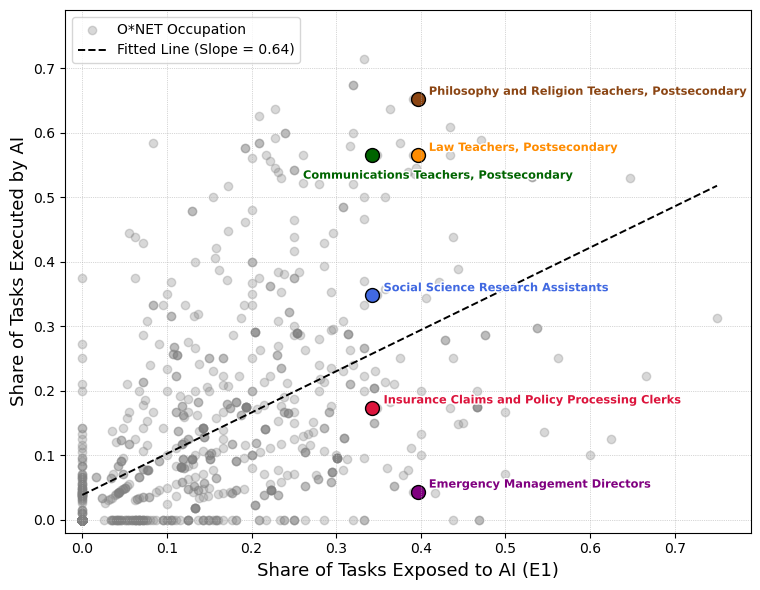

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import os

# --- same data prep as above --- 
occupation_analysis = create_occupation_analysis(merged_data, 'O*NET-SOC Code', 'Occupation Title')
fi_df = construct_fragmentation_index(merged_data, desired_definition=2)
occupation_analysis = merge_fragmentation_with_occupation_analysis(
    fi_df, occupation_analysis, SOC_mappings, onet_occupation_code_var, save_filename=None
)
occupation_analysis_aggregated = aggregate_occupation_analysis(
    occupation_analysis, onet_occupation_code_var, onet_occupation_title_var, SOC_mappings, ai_exposure_var
)
occupation_analysis_aggregated = occupation_analysis_aggregated.rename(columns={ai_exposure_var: 'ai_exposure'})
os.makedirs(output_plot_path, exist_ok=True)

highlight_map = {
    '43-9041': 'crimson',
    '19-4061': 'royalblue',
    '25-1122': 'darkgreen',
    '11-9161': 'purple',
    '25-1112': 'darkorange',
    '25-1126': 'saddlebrown'
}

legend_map = {
    '43-9041': 'Insurance Claims and Policy Processing Clerks',
    '19-4061': 'Social Science Research Assistants',
    '25-1122': 'Communications Teachers, Postsecondary',
    '11-9161': 'Emergency Management Directors',
    '25-1112': 'Law Teachers, Postsecondary',
    '25-1126': 'Philosophy and Religion Teachers, Postsecondary'
}

group1 = ['43-9041','19-4061','25-1122']
group2 = ['11-9161','25-1112','25-1126']
jitter_amount = 0.005

offsets_B = {
    '25-1122': (-50, -17),
    '43-9041': (8, 3),
    '19-4061': (8, 3),
    '11-9161': (8, 3),
    '25-1112': (8, 3),
    '25-1126': (8, 3)
}

# ----- FIGURE -----
plt.figure(figsize=(8,6))
ax = plt.gca()

df_plot = occupation_analysis_aggregated.dropna(subset=['ai_fraction','ai_exposure']).copy()
x = df_plot['ai_exposure']
y = df_plot['ai_fraction']

# Background cloud
ax.scatter(x, y, alpha=0.3, color='gray', label='O*NET Occupation')

# Trendline
if len(x):
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 200)
    ax.plot(xs, m*xs + b, color='black', linestyle='--', linewidth=1.4, label=f'Fitted Line (Slope = {m:.2f})')

# Highlight + annotate
for soc_code, color in highlight_map.items():
    sub = df_plot[df_plot[onet_occupation_code_var] == soc_code]
    if not sub.empty:
        hx = sub['ai_exposure'].iloc[0]
        hy = sub['ai_fraction'].iloc[0]
        if soc_code in group1: hx -= jitter_amount
        elif soc_code in group2: hx += jitter_amount

        ax.scatter(hx, hy, s=100, color=color, edgecolors='black', linewidth=1)

        dx, dy = offsets_B[soc_code]
        ax.annotate(
            legend_map[soc_code], 
            xy=(hx, hy), 
            xytext=(dx, dy),
            textcoords='offset points',
            fontsize=8.2, 
            color=color,
            weight='bold',
            path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
        )

r = np.corrcoef(x, y)[0,1] if len(x)>1 else np.nan

ax.set_xlabel("Share of Tasks Exposed to AI (E1)", fontsize=13)
ax.set_ylabel("Share of Tasks Executed by AI", fontsize=13)
# ax.set_title(f"AI Fraction vs AI Exposure (r={r:.2f})")
ax.grid(True, linestyle=':', linewidth=0.5)
ax.set_xlim(-0.02, 0.79)
ax.set_ylim(-0.02, 0.79)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(output_plot_path, "aiFraction_vs_aiExposure.png"), dpi=300)
plt.show()

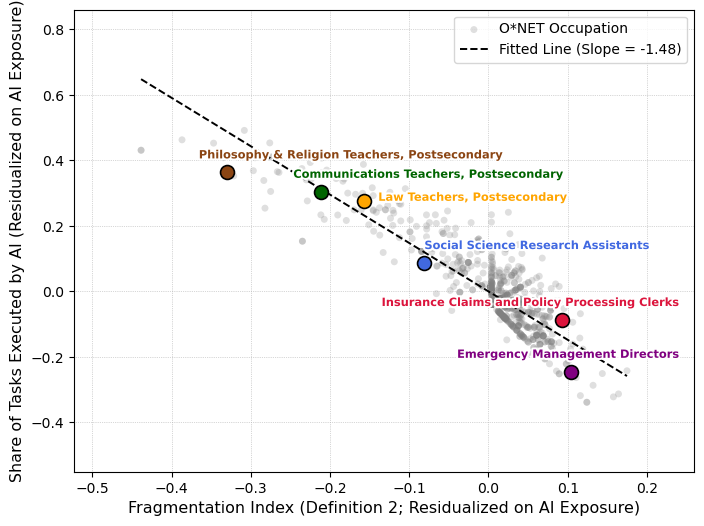

Saved figure to: ../writeup/plots/fragmentationIndex/partial_regression_fragmentation_aiFraction.png


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os

# ---- PREP SHARED DATA ----
occupation_analysis = create_occupation_analysis(merged_data, 'O*NET-SOC Code', 'Occupation Title')
fi_df = construct_fragmentation_index(merged_data, desired_definition=2)
occupation_analysis = merge_fragmentation_with_occupation_analysis(
    fi_df, occupation_analysis, SOC_mappings, onet_occupation_code_var, save_filename=None
)
occupation_analysis_aggregated = aggregate_occupation_analysis(
    occupation_analysis, onet_occupation_code_var, onet_occupation_title_var, SOC_mappings, ai_exposure_var
)
occupation_analysis_aggregated = occupation_analysis_aggregated.rename(columns={ai_exposure_var: 'ai_exposure'})
df = occupation_analysis_aggregated.copy()

# ---- Highlighted SOCs ----
highlight_socs = [
    '43-9041', '19-4061', '25-1122',
    '11-9161', '25-1112', '25-1126'
]

highlight_map = {
    '43-9041': 'crimson',
    '19-4061': 'royalblue',
    '25-1122': 'darkgreen',
    '11-9161': 'purple',
    '25-1112': 'orange',
    '25-1126': 'saddlebrown'
}

legend_map = {
    '43-9041': 'Insurance Claims and Policy Processing Clerks',
    '19-4061': 'Social Science Research Assistants',
    '25-1122': 'Communications Teachers, Postsecondary',
    '11-9161': 'Emergency Management Directors',
    '25-1112': 'Law Teachers, Postsecondary',
    '25-1126': 'Philosophy & Religion Teachers, Postsecondary'
}

# ---------- PARTIAL REGRESSION ----------
Y = df["ai_fraction"]
X = df["fragmentation_index"]
C = df["ai_exposure"]

Xc = sm.add_constant(C)

resid_y = sm.OLS(Y, Xc).fit().resid
resid_x = sm.OLS(X, Xc).fit().resid

df["_resid_y"] = resid_y
df["_resid_x"] = resid_x

# ---------- PLOT ----------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

offsets_B = {
    '25-1122': (-20, 10),
    '43-9041': (-130, 10),
    '19-4061': (0, 10),
    '11-9161': (-82, 10),
    '25-1112': (10, 0),
    '25-1126': (-20, 10),
}


# Keep plot centered in figure canvas
ax.set_anchor('C')

# Background cloud
ax.scatter(df["_resid_x"], df["_resid_y"], alpha=0.25, s=25, 
           color="gray", edgecolors="none", label="O*NET Occupation")

# Trendline
m, b = np.polyfit(df["_resid_x"], df["_resid_y"], 1)
xs = np.linspace(df["_resid_x"].min(), df["_resid_x"].max(), 200)
ax.plot(xs, m*xs + b, color="black", linestyle="--", linewidth=1.4, label=f'Fitted Line (Slope = {m:.2f})')

# Highlight SOCs
for soc_code in highlight_socs:
    row = df[df[onet_occupation_code_var] == soc_code]
    if not row.empty:
        xh = row["_resid_x"].iloc[0]
        yh = row["_resid_y"].iloc[0]
        color = highlight_map[soc_code]

        ax.scatter(xh, yh, s=100, color=color, edgecolors="black", linewidth=1.2, zorder=3)

        ax.annotate(
            legend_map[soc_code],
            xy=(xh, yh),
            xytext=offsets_B[soc_code],
            textcoords="offset points",
            fontsize=8.2,
            color=color,
            weight="bold",
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

# Labels
r = np.corrcoef(df["_resid_x"], df["_resid_y"])[0, 1]

ax.set_xlabel("Fragmentation Index (Definition 2; Residualized on AI Exposure)", fontsize=11.5)
ax.set_ylabel("Share of Tasks Executed by AI (Residualized on AI Exposure)", fontsize=11.5)
ax.grid(True, linestyle=":", linewidth=0.5)
ax.legend(loc="upper right")

# ---- ADJUST BOUNDS TO ENSURE TEXT IS VISIBLE ----
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_xlim(x0 - 0.08*(x1-x0), x1 + 0.08*(x1-x0))
ax.set_ylim(y0 - 0.15*(y1-y0), y1 + 0.15*(y1-y0))

# Save with full bounding box
outfile = os.path.join(output_plot_path, "partial_regression_fragmentation_aiFraction.png")
plt.savefig(outfile, dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

print(f"Saved figure to: {outfile}")

In [15]:
df_plot[(df_plot['ai_exposure'] >= 0.3) & (df_plot['ai_exposure'] <= 0.4)].drop_duplicates(subset=[onet_occupation_code_var])[[onet_occupation_code_var, onet_occupation_title_var, 'num_tasks', 'ai_exposure', 'fragmentation_index', 'ai_fraction']].sort_values(by=['num_tasks', 'ai_exposure', 'fragmentation_index'], ascending=False)

,Detailed_Occupation_Code,Detailed_Occupation_Title,num_tasks,ai_exposure,fragmentation_index,ai_fraction
283,25-1123,"English Language and Literature Teachers, Post...",33.00,0.39,0.76,0.55
202,19-2042,"Geoscientists, Except Hydrologists and Geograp...",32.00,0.31,0.97,0.09
336,27-3023,"News Analysts, Reporters, and Journalists",30.00,0.40,1.00,0.13
209,19-3033,Clinical and Counseling Psychologists,30.00,0.33,0.97,0.20
27,11-9033,"Education Administrators, Postsecondary",29.00,0.38,1.00,0.07
281,25-1121,"Art, Drama, and Music Teachers, Postsecondary",28.00,0.39,0.75,0.54
67,13-1081,Logisticians,27.67,0.35,0.97,0.20
195,19-2021,Atmospheric and Space Scientists,27.00,0.33,1.00,0.22
106,15-1253,Software Quality Assurance Analysts and Testers,27.00,0.33,0.78,0.37
147,17-2141,Mechanical Engineers,26.33,0.31,0.97,0.13
